Using device: cuda
Training started for 2000 epochs...
Epoch 100/2000, Total Loss: 0.220670
Epoch 200/2000, Total Loss: 0.216841
Epoch 300/2000, Total Loss: 0.212595
Epoch 400/2000, Total Loss: 0.211420
Epoch 500/2000, Total Loss: 0.211035
Epoch 600/2000, Total Loss: 0.210793
Epoch 700/2000, Total Loss: 0.210368
Epoch 800/2000, Total Loss: 0.208768
Epoch 900/2000, Total Loss: 0.202861
Epoch 1000/2000, Total Loss: 0.186386
Epoch 1100/2000, Total Loss: 0.157500
Epoch 1200/2000, Total Loss: 0.115893
Epoch 1300/2000, Total Loss: 0.100711
Epoch 1400/2000, Total Loss: 0.095167
Epoch 1500/2000, Total Loss: 0.092430
Epoch 1600/2000, Total Loss: 0.090818
Epoch 1700/2000, Total Loss: 0.089756
Epoch 1800/2000, Total Loss: 0.089000
Epoch 1900/2000, Total Loss: 0.088432
Epoch 2000/2000, Total Loss: 0.087986

--- Training complete. Running simulation with trained model. ---

--- Running simulation with fixed a1=1.0 for comparison. ---


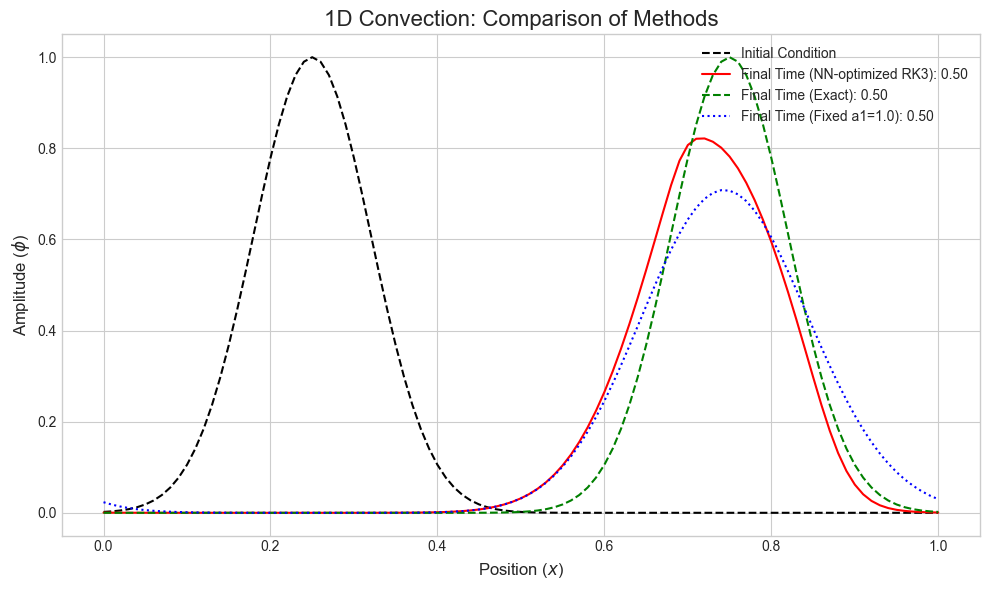

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class A1Network(nn.Module):
    def __init__(self):
        super(A1Network, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), # Input is (x, t)
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid() # Constrain output to [0, 1]
        )

    def forward(self, x, t):
        inputs = torch.stack([x, t], dim=1)
        return self.net(inputs).squeeze()

def rk3_step_torch(phi, x, t, u, dt, dx, a1_model):
    """
    Performs a single RK3 time step using a PyTorch model for a1.
    """
    # Get a1 values from the neural network
    a1_values = a1_model(x, torch.full_like(x, t))

    # Perform RK3 stages using PyTorch operations
    # Stage 1
    phi_star_1 = phi - a1_values * u * (dt / dx) * (phi - torch.roll(phi, shifts=1, dims=0))

    # Stage 2
    phi_star_2 = (3/4) * phi + (1/4) * (phi_star_1 - u * (dt / dx) * (phi_star_1 - torch.roll(phi_star_1, shifts=1, dims=0)))

    # Stage 3
    phi_new = (1/3) * phi + (2/3) * (phi_star_2 - u * (dt / dx) * (phi_star_2 - torch.roll(phi_star_2, shifts=1, dims=0)))

    return phi_new

def rk3_step_fixed_a1(phi, u, dt, dx, a1_value=1.0):
    """
    Performs a single RK3 time step with a fixed, constant a1 value.
    """
    # Stage 1
    phi_star_1 = phi - a1_value * u * (dt / dx) * (phi - torch.roll(phi, shifts=1, dims=0))

    # Stage 2
    phi_star_2 = (3/4) * phi + (1/4) * (phi_star_1 - u * (dt / dx) * (phi_star_1 - torch.roll(phi_star_1, shifts=1, dims=0)))

    # Stage 3
    phi_new = (1/3) * phi + (2/3) * (phi_star_2 - u * (dt / dx) * (phi_star_2 - torch.roll(phi_star_2, shifts=1, dims=0)))

    return phi_new

# Simulation parameters
NUM_POINTS = 101
DOMAIN_LENGTH = 1.0
TOTAL_TIME = 0.5
ADVECTION_VELOCITY = 1.0
CFL_NUMBER = 0.8

dx = DOMAIN_LENGTH / (NUM_POINTS - 1)
dt = CFL_NUMBER * dx / ADVECTION_VELOCITY
nt = int(TOTAL_TIME / dt) + 1
x_np = np.linspace(0, DOMAIN_LENGTH, NUM_POINTS)

# Create the a1 model and optimizer
a1_model = A1Network().to(device)
optimizer = optim.Adam(a1_model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Exact solution for loss calculation (pre-computed for all time steps)
x_torch = torch.from_numpy(x_np).float().to(device)
phi_initial_np = np.exp(-((x_np - DOMAIN_LENGTH / 4)**2) / 0.01)
phi_exact_np_all_times = np.array([
    np.exp(-((x_np - (DOMAIN_LENGTH / 4 + ADVECTION_VELOCITY * t))**2) / 0.01)
    for t in np.arange(0, TOTAL_TIME, dt)
])
phi_exact_torch_all_times = torch.from_numpy(phi_exact_np_all_times).float().to(device)

# Training loop
epochs = 2000
print(f"Training started for {epochs} epochs...")
for epoch in range(epochs):
    # Initial condition for each epoch
    phi_torch = torch.from_numpy(phi_initial_np).float().to(device)
    total_loss = torch.tensor(0.0, requires_grad=True).to(device)

    # Run the full simulation and accumulate loss
    current_time = 0.0
    for i in range(nt - 1):
        phi_torch = rk3_step_torch(phi_torch, x_torch, current_time, ADVECTION_VELOCITY, dt, dx, a1_model)
        
        # Calculate loss for the current time step and add to total
        loss_step = loss_function(phi_torch, phi_exact_torch_all_times[i])
        total_loss = total_loss + loss_step

        current_time += dt

    # Backpropagation on the total loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss.item():.6f}")

# --- Plotting the result of the trained model ---
print("\n--- Training complete. Running simulation with trained model. ---")

# Run the final simulation with the trained model
with torch.no_grad():
    phi_torch = torch.from_numpy(phi_initial_np).float().to(device)
    current_time = 0.0
    for _ in range(nt - 1):
        phi_torch = rk3_step_torch(phi_torch, x_torch, current_time, ADVECTION_VELOCITY, dt, dx, a1_model)
        current_time += dt
phi_learned = phi_torch.cpu().numpy()

# --- Run simulation with a fixed a1=1.0 for comparison ---
print("\n--- Running simulation with fixed a1=1.0 for comparison. ---")
phi_fixed_a1 = torch.from_numpy(phi_initial_np).float().to(device)
with torch.no_grad():
    for _ in range(nt - 1):
        phi_fixed_a1 = rk3_step_fixed_a1(phi_fixed_a1, ADVECTION_VELOCITY, dt, dx, a1_value=1.0)
phi_fixed_a1_np = phi_fixed_a1.cpu().numpy()

phi_exact_final_np = np.exp(-((x_np - (DOMAIN_LENGTH / 4 + ADVECTION_VELOCITY * TOTAL_TIME))**2) / 0.01)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_np, phi_initial_np, 'k--', label='Initial Condition')
ax.plot(x_np, phi_learned, 'r-', label=f'Final Time (NN-optimized RK3): {TOTAL_TIME:.2f}')
ax.plot(x_np, phi_exact_final_np, 'g--', label=f'Final Time (Exact): {TOTAL_TIME:.2f}')
ax.plot(x_np, phi_fixed_a1_np, 'b:', label=f'Final Time (Fixed a1=1.0): {TOTAL_TIME:.2f}')

ax.set_title(f'1D Convection: Comparison of Methods', fontsize=16)
ax.set_xlabel('Position ($x$)', fontsize=12)
ax.set_ylabel('Amplitude ($\phi$)', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()
